In [1]:
import sys 
sys.path.insert(0,'../')

%matplotlib inline
from scripts.Deblender import Deblend
from scripts.utils import listdir_fullpath

import numpy as np
import os

import matplotlib.pyplot as plt

import btk
import btk.plot_utils
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions
import astropy.table

import tensorflow as tf
import tensorflow_probability as tfp
tf.get_logger().setLevel('ERROR')

2022-04-25 23:19:53.808105: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/:
2022-04-25 23:19:53.808164: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
COSMOS_CATALOG_PATHS = [
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2.fits",
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2_fits.fits",
]


stamp_size = 100
max_number = 60
batch_size = 1
max_shift = 44
catalog = btk.catalog.CosmosCatalog.from_file(COSMOS_CATALOG_PATHS)
survey = btk.survey.get_surveys("Rubin")
seed=3

import galsim 
galsim_catalog = galsim.COSMOSCatalog(COSMOS_CATALOG_PATHS[0], exclusion_level="marginal")

sampling_function = btk.sampling_functions.DefaultSampling(max_number=max_number, maxshift=max_shift, stamp_size=stamp_size, seed=seed)

draw_generator = btk.draw_blends.CosmosGenerator(
    catalog,
    sampling_function,
    survey,
    batch_size=batch_size,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="all",
    verbose=False,
    gal_type="parametric",
    seed=seed,
)

In [3]:
def crop_image(image, pos, cutout_size):
    """
    crops a portion of the image.
    
    Parameters
    ----------
    image:
    
    pos:
    
    cutout_size: float
        cutout size in arcminutes
    
    Returns
    -------
    cropped image
    """
    
    cutout_pixel_size = int(cutout_size * 5)
    
    x_crop_start = int(pos[0] - (cutout_pixel_size-1)/2)
    x_crop_end = int(pos[0] + (cutout_pixel_size-1)/2)
    
    y_crop_start = int(pos[1] - (cutout_pixel_size-1)/2)
    y_crop_end = int(pos[1] + (cutout_pixel_size-1)/2)
    
    #print(np.shape(image))
    #print(pos)
    #print(x_crop_start)
    #print(x_crop_end+1)
    cropped_image = image[2, x_crop_start:x_crop_end+1, y_crop_start:y_crop_end+1]
    
    #print(np.shape(crop_image))
    return cropped_image.copy()


In [4]:
blend = next(draw_generator)

blend['blend_list'][0]['x_peak']

np.shape(blend['blend_images'][0])

(6, 500, 500)

input_image


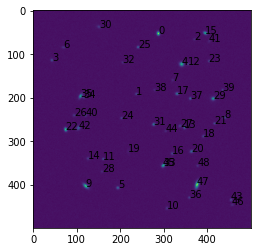

In [5]:
print("input_image")
plt.imshow(blend['blend_images'][0, 2])
for i in range(len(blend['blend_list'][0])):
    plt.text(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], str(i))

input_image


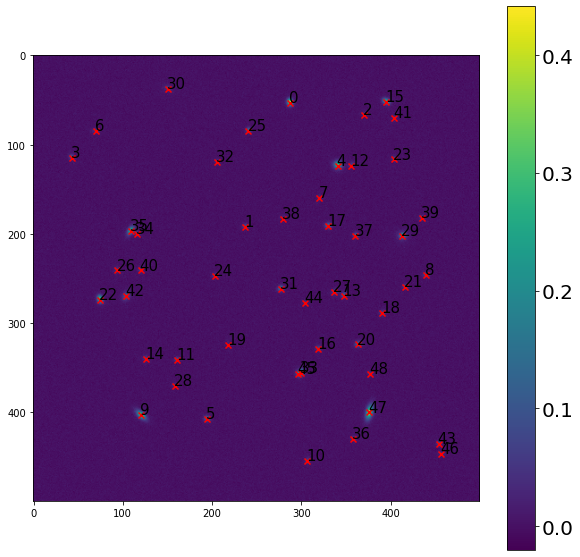

In [6]:
print("input_image")
fig=plt.figure(figsize=(10,10))
ax=fig.gca()
im1 = ax.imshow(blend['blend_images'][0, 2]/80000)
for i in range(len(blend['blend_list'][0])):
    plt.scatter(blend['blend_list'][0]['x_peak'][i], 
                blend['blend_list'][0]['y_peak'][i], marker="x", c="r")
    plt.text(blend['blend_list'][0]['x_peak'][i]-1, blend['blend_list'][0]['y_peak'][i]-1, str(i), fontsize=15)
cbar = fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.savefig("input field")

In [7]:
tf.get_logger().setLevel('ERROR')

detected_positions = []
for i in range(len(blend['blend_list'][0])):
    detected_positions.append([blend['blend_list'][0]['y_peak'][i], blend['blend_list'][0]['x_peak'][i]])

deb = Deblend(blend['blend_images'][0]/80000, 
              detected_positions,
              latent_dim=10, 
              num_components=len(blend['blend_list'][0]), 
              use_likelihood=True, 
              max_iter=300)

2022-04-25 23:20:20.773233: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/:
2022-04-25 23:20:20.773320: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-25 23:20:20.773371: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jns-bbiswas.cc.in2p3.fr): /proc/driver/nvidia/version does not exist
2022-04-25 23:20:20.773851: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-25 2

In [8]:
#deb.run_debvader()

In [9]:
#fig, ax = plt.subplots(len(blend['blend_list'][0]), 3, figsize=(5*3,5*len(blend['blend_list'][0])))

#for i in range(len(blend['blend_list'][0])):

    #print("image number: " + str(i))
    #image_index = shuffled_indices[i]
#     im1 = ax[i, 0].imshow(crop_image(blend['isolated_images'][0][i]/80000, detected_positions[i], 9))
#     cbar = fig.colorbar(im1, ax=ax[i, 0])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 0].set_title("ground truth")
#     ax[i, 0].scatter(22, 22, c="r", marker="x")

#     im2 = ax[i, 1].imshow(deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im2, ax=ax[i, 1])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 1].set_title("predicted")
    
#     im3 = ax[i, 2].imshow(crop_image(blend['isolated_images'][0][i]/80000, detected_positions[i], 9) - deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im3, ax=ax[i, 2])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 2].set_title("actual - predicted")
    
# plt.show()

In [10]:
# fig = plt.figure(figsize=(10,10))
# ax = fig.gca()
# padding_infos = deb.get_padding_infos()
# residual = deb.compute_residual(blend['blend_images'][0]/80000, use_scatter_and_sub=True).numpy()
# #residual = np.transpose(deb.postage_stamp, 
# im1 = ax.imshow(residual[:, :, 2])
# cbar =fig.colorbar(im1, ax=ax)
# cbar.ax.tick_params(labelsize=20)
# plt.savefig("residual")

In [11]:
tf.config.run_functions_eagerly(False)
convergence_criterion = tfp.optimizer.convergence_criteria.LossNotDecreasing(atol=.0000015*45*45*6*49, min_num_steps=50, window_size=20)
#convergence_criterion = None
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.075, decay_steps=12, decay_rate=0.75, staircase=True)
optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_scheduler)

deb(convergence_criterion, optimizer=optimizer)


--- Starting gradient descent in the latent space ---
Maximum number of iterations: 300
Number of Galaxies: 49
Dimensions of latent space: 10
--- Gradient descent complete ---

Time taken for gradient descent: 61.58450174331665


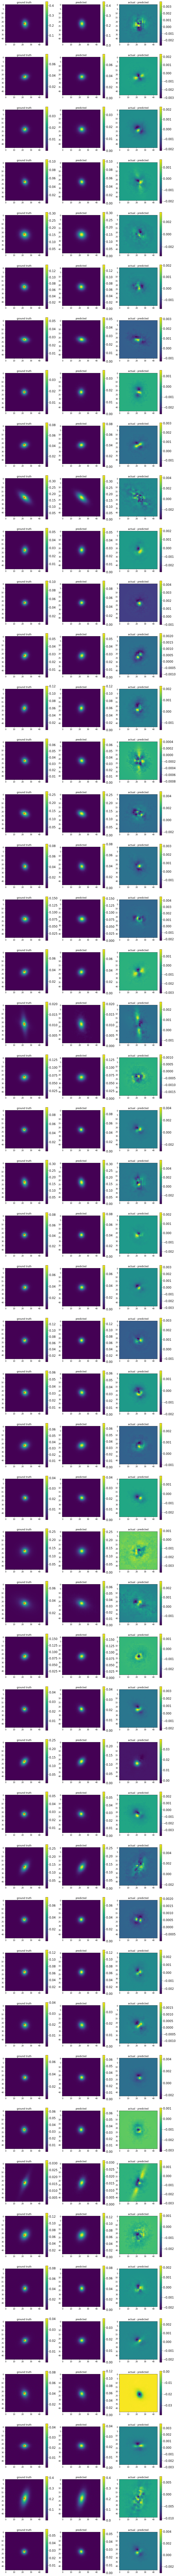

In [12]:
fig, ax = plt.subplots(len(blend['blend_list'][0]), 3, figsize=(5*3,5*len(blend['blend_list'][0])))

for i in range(len(blend['blend_list'][0])):

    #print("image number: " + str(i))
    #image_index = shuffled_indices[i]
    im1 = ax[i, 0].imshow(crop_image(blend['isolated_images'][0][i]/80000, detected_positions[i], 9))
    cbar = fig.colorbar(im1, ax=ax[i, 0])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 0].set_title("ground truth")
    ax[i, 0].scatter(22, 22, c="r", marker="x")

    im2 = ax[i, 1].imshow(deb.components[i][:, :, 2])
    cbar = fig.colorbar(im2, ax=ax[i, 1])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 1].set_title("predicted")
    
    im3 = ax[i, 2].imshow(crop_image(blend['isolated_images'][0][i]/80000, detected_positions[i], 9) - deb.components[i][:, :, 2])
    cbar = fig.colorbar(im3, ax=ax[i, 2])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 2].set_title("actual - predicted")
    
plt.show()

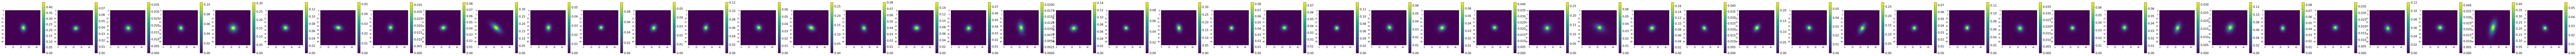

In [13]:
fig, ax = plt.subplots(1, len(blend['blend_list'][0]), figsize=(5*len(blend['blend_list'][0]), 5*1))
for i in range(len(blend['blend_list'][0])):

    #print("image number: " + str(i))
    #image_index = shuffled_indices[i]

    im2 = ax[i].imshow(deb.components[i][:, :, 2])
    cbar = fig.colorbar(im2, ax=ax[i])
    cbar.ax.tick_params(labelsize=15)
    #ax[i].set_title("predicted")
plt.savefig("predictions")

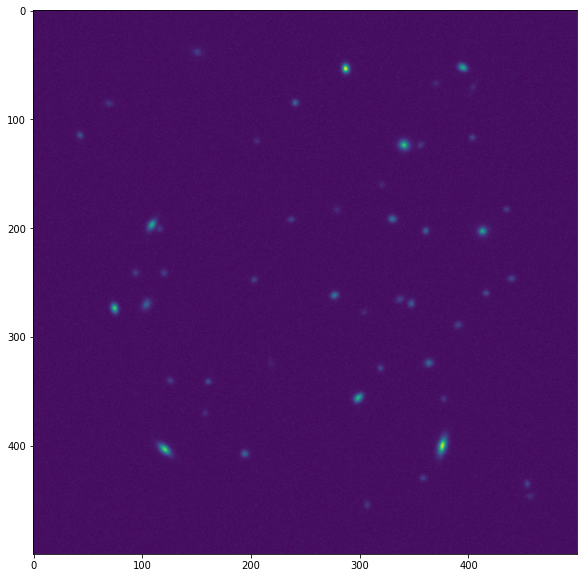

In [14]:
fig = plt.figure(figsize=(10,10))
plt.imshow(blend['blend_images'][0][1])

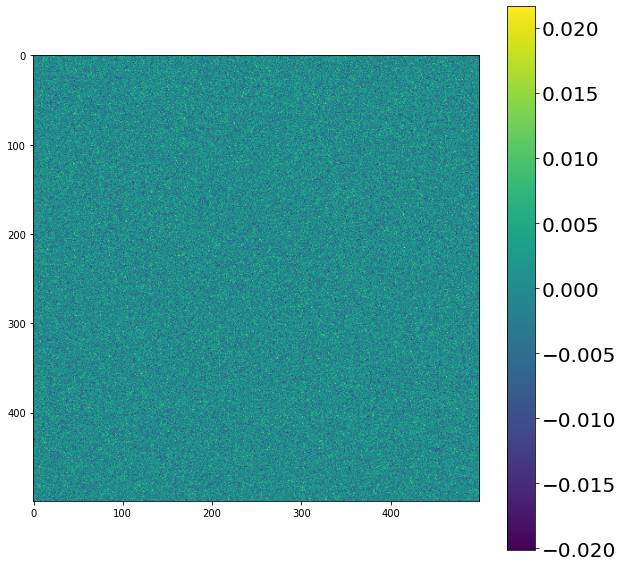

In [15]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
tf.config.run_functions_eagerly(True)

padding_infos = deb.get_padding_infos()
residual = deb.compute_residual(blend['blend_images'][0]/80000, use_scatter_and_sub=True).numpy()
#residual = np.transpose(deb.postage_stamp, 
im1 = ax.imshow(residual[:, :, 2])
cbar =fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.savefig("residual")
#for i in range(len(blend['blend_list'][0])):
    #plt.scatter(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], marker="x", linewidths=.5, s=120, c="r")

tf.Tensor(
[749843.9  787188.06 767345.44 762017.1  761778.75 758990.6  757190.4
 755398.06 755307.3  754982.1  754941.   755026.06 754404.5  753447.8
 753065.25 752904.6  752702.9  752676.25 752778.4  752995.   752711.06
 752876.75 752784.1  752861.4  752799.4  752023.9  751673.06 751564.2
 751469.44 751485.9  751486.5  751666.2  751646.8  751777.75 751844.75
 751755.3  751856.2  751156.25 750932.06 750857.   750819.25 750801.3
 750793.3  750827.56 750870.56 750969.1  750976.94 751068.1  751116.9
 750653.1  750555.7  750498.8  750488.4  750455.8  750459.8  750449.06
 750473.9  750514.4  750583.3  750621.75 750682.   750403.   750330.9
 750304.56 750281.1  750280.8  750260.4  750281.06 750264.7  750292.8
 750287.8  750327.4  750349.2  750240.8  750212.56 750199.25 750194.94
 750193.1  750191.8  750196.8  750200.9  750210.44 750232.75 750244.1
 750269.4  750171.   750166.44 750156.44 750156.25 750160.1  750157.
 750168.44 750165.3  750170.5  750168.56 750164.5  750173.5  750139.5
 75014

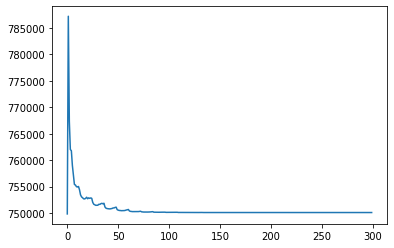

In [16]:
print(deb.results)
plt.plot(deb.results)